# GoEmotions No Context Evaluation

In [1]:
from sympy.printing.pretty.pretty_symbology import line_width
from transformers import AutoTokenizer, BertForSequenceClassification
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import Counter
from scipy.stats import entropy

In [2]:
sns.set(rc={'figure.figsize':(12, 8)})

## Data

In [3]:
#!wget https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/emotions.txt

## Preparations

In [4]:
labels_df = pd.read_csv('emotions.txt', header=None)
ID_TO_EMOTION = dict(labels_df[0])
EMOTION_TO_ID = {emotion: emotion_id for emotion_id, emotion in ID_TO_EMOTION.items()}

In [5]:
GPT_EVALUTION_FILE_PATH = r"test.tsv"

### Load pretrained model

In [6]:
tokenizer = AutoTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-original")
model = BertForSequenceClassification.from_pretrained("monologg/bert-base-cased-goemotions-original")

In [7]:
model.resize_token_embeddings(len(tokenizer))

Embedding(28996, 768, padding_idx=0)

In [8]:
gpt_evaluation_df = pd.read_csv(GPT_EVALUTION_FILE_PATH, sep="\t")

In [9]:
gpt_evaluation_df.iloc[:, 0].head(2)

0      It's wonderful because it's awful. At not with.
1    Kings fan here, good luck to you guys! Will be...
Name: I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!, dtype: object

## Encode model predictions

In [10]:
def encode_one_hot(annotations: list[str]):
    one_hot = np.zeros(len(ID_TO_EMOTION), dtype="bool")
    for emotion in annotations:
        one_hot[EMOTION_TO_ID[emotion]] = 1
    return one_hot

labels_df = pd.read_csv('emotions.txt', header=None)
labels = labels_df.values[:,0].tolist()

split_values = gpt_evaluation_df.iloc[:, 1].str.split(',').apply(lambda x: list(map(int, x)))

gpt_evaluation_df["true_labels"] = split_values.apply(
    lambda indices: encode_one_hot([labels[i] for i in indices])
)

### Get model predictions

In [11]:
def get_model_predictions(text: str) -> np.ndarray:
    inputs = tokenizer(text, return_tensors="pt")
    logits = model(**inputs).logits
    return (torch.sigmoid(logits).squeeze(dim=0) > 0.5).numpy()

In [12]:
gpt_evaluation_df["sota_labels"] = gpt_evaluation_df.iloc[:, 0].apply(
    get_model_predictions
)

### SOTA

In [13]:
accuracy_score(
    y_true=np.array(gpt_evaluation_df["true_labels"].tolist()),
    y_pred=np.array(gpt_evaluation_df["sota_labels"].tolist()),
)

0.45171396977515665

In [14]:
macro_f1_score = f1_score(
    y_true=np.array(gpt_evaluation_df["true_labels"].tolist()),
    y_pred=np.array(gpt_evaluation_df["sota_labels"].tolist()),
    average='macro',
)
macro_f1_score

0.496722101595925

In [15]:
precision_score(
    y_true=np.array(gpt_evaluation_df["true_labels"].tolist()),
    y_pred=np.array(gpt_evaluation_df["sota_labels"].tolist()),
    average='macro',
    zero_division=0,
)

0.5187499663954103

In [16]:
recall_score(
    y_true=np.array(gpt_evaluation_df["true_labels"].tolist()),
    y_pred=np.array(gpt_evaluation_df["sota_labels"].tolist()),
    average='macro',
)

0.4857405718401462

## Per class metrics

In [17]:
metrics = []
for emotion, emotion_id in EMOTION_TO_ID.items():
    true_labels = gpt_evaluation_df["true_labels"].apply(lambda labels: labels[emotion_id]).values
    sota_labels = gpt_evaluation_df["sota_labels"].apply(lambda labels: labels[emotion_id]).values
    metrics.append(
        {
            "Emotion": emotion,
            "Emotion ID": emotion_id,
            "Accuracy": accuracy_score(
                y_true=true_labels,
                y_pred=sota_labels,
            ),
            "F1Score": f1_score(
                y_true=true_labels,
                y_pred=sota_labels,
            ),
            "Model": "SOTA",
        }
    )
metrics_df = pd.DataFrame(metrics)

In [18]:
metrics_df[metrics_df["Model"] == "SOTA"]["F1Score"].tolist()

[0.6779661016949152,
 0.8006993006993007,
 0.47752808988764045,
 0.33986928104575165,
 0.371900826446281,
 0.40625,
 0.43478260869565216,
 0.5133333333333333,
 0.46808510638297873,
 0.25547445255474455,
 0.3850467289719626,
 0.5398230088495575,
 0.49230769230769234,
 0.39603960396039606,
 0.6863905325443787,
 0.9051724137931034,
 0.0,
 0.5933333333333334,
 0.7757575757575758,
 0.3076923076923077,
 0.554016620498615,
 0.4166666666666667,
 0.22666666666666666,
 0.4444444444444444,
 0.7142857142857143,
 0.5292096219931272,
 0.5539568345323741,
 0.6415199776473876]

[Text(0.5, 1.0, 'SOTA scores for GoEmotions')]

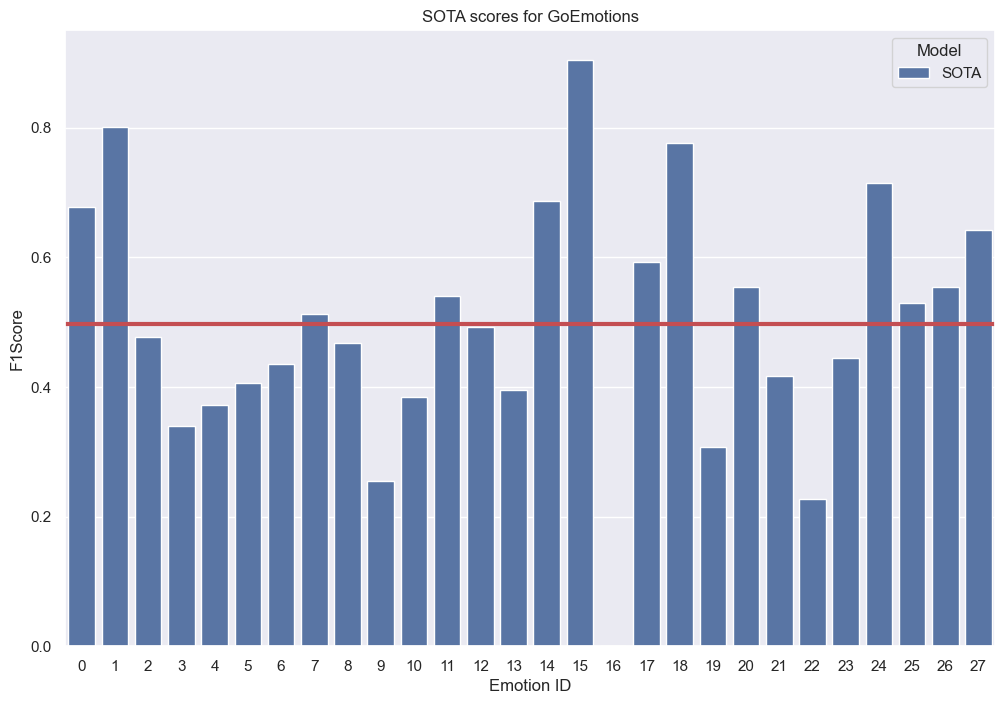

In [19]:
fig = sns.barplot(
    data=metrics_df,
    x="Emotion ID",
    y="F1Score",
    hue="Model")

fig.axhline(macro_f1_score, color="r", linewidth=3)

fig = fig.set(title="SOTA scores for GoEmotions")

#plt.xticks(rotation=45)
fig

## Save results

In [22]:
gpt_evaluation_df.to_csv("results.csv", sep=";")
# Best & Worst GPT predictions
columns = ["text", "prompt", "annotation", "sota_score", "sota_labels"]
gpt_evaluation_df[:].head(10).to_csv("results.csv", sep=";")
gpt_evaluation_df[:].tail(10).to_csv("results.csv", sep=";")